In [1]:
import sys
import numpy as np
import math
import pandas as pd
import random

from scipy import stats

%matplotlib inline

import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rc('font',family='serif')
matplotlib.rc('font',weight='bold')
matplotlib.rc('font',size=16)
matplotlib.rcParams['axes.labelweight'] = 'bold'

from recommender_functions import *
from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, roc_auc_score

In [2]:
week = 'Week3'
day  = 'Mon'

In [3]:
# Get the ratings by user ID: starts at user index 1 
r = pd.read_csv('goodbooks-10k/ratings.csv')
df_ratings = pd.DataFrame(r)

# Add counts to the df
cut_u, cut_b = 175, 1 #175, 1
df_ratings['user_counts'] = df_ratings.groupby(['user_id'])['book_id'].transform('count')
df_ratings['book_counts'] = df_ratings.groupby(['book_id'])['user_id'].transform('count')
df_ratings_cut = df_ratings.query('user_counts > %d '%(cut_u))

# Add an index for the user for matrix making later
df_ratings_cut['user_idx'] = pd.Categorical(df_ratings_cut['user_id']).codes 
df_ratings_cut['book_idx'] = pd.Categorical(df_ratings_cut['book_id']).codes 

# ...but also do a groupby, so can plot easily
df_ratings_count_u = df_ratings.groupby(['user_id']).size().reset_index(name='Counts')

r = pd.read_csv('goodbooks-10k/books_with_genres.csv')
df_books = pd.DataFrame(r)
df_ratings_cut.head()

r = pd.read_csv('goodbooks-10k/ahack_tags_3.csv')
df_tags = pd.DataFrame(r)
df_tags['tag_index'] = pd.Categorical(df_tags['tag_id']).codes 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [4]:
# Set number of books and users variables for later use
N_BOOKS = len(df_ratings_cut.book_id.unique()) #df_books.shape[0]
N_USERS = len(df_ratings_cut.user_id.unique())

print(N_BOOKS,N_USERS)# ,df_ratings_count_u_cut.shape[0])

7337 537


In [5]:
df_books.head()
df_tags.head()

,tag_id,tag_name,tag_index
0,1691,adventure,0
1,2580,animals,1
2,2768,apocalyptic,2
3,2938,art,3
4,4605,biography,4


## Build a Rank Matrix

In [6]:
# First, define a matrix size num_books x num_users
ratings_genre_mat = np.zeros((N_USERS,N_BOOKS))
ratings_mat = np.zeros((N_USERS,N_BOOKS))
binary_mat = np.zeros((N_USERS,N_BOOKS))

Y, R = ratings_mat, binary_mat
in_genre = 'fantasy'

genre_list_dict = []

# Now fill the rank matrix and validation matrix
for i in range(df_ratings_cut.shape[0]):
    user_i = df_ratings_cut.user_idx.values[i]
    book_i = df_ratings_cut.book_idx.values[i]
    rating_i = df_ratings_cut.rating.values[i]
    
    #ratings_genre_mat[user_i][book_i] = rating_i
    ratings_mat[user_i][book_i] = rating_i
    binary_mat[user_i][book_i] = 1
    
    actual_book_i = df_ratings_cut.book_id.values[i]
    book_q = df_books[df_books['book_id'].isin([actual_book_i])]
    genre, tag_id = book_q.genre.values[0], book_q.tag_id.values[0]
    ratings_genre_mat[user_i][book_i] = int(tag_id)    

#    if genre == in_genre:
#        ratings_genre_mat[user_i][book_i] = tag_id
#         if ratings_genre_mat[user_i][book_i] == 0:
#             ratings_genre_mat[user_i][book_i] = 3
#         else:
#             ratings_genre_mat[user_i][book_i] *= 1.1

In [7]:
#print(ratings_genre_mat,ratings_genre_mat.shape)
top_3_genres_per_user = np.zeros((N_USERS,4))
top_3_genres_names_per_user = []

for rowi in range(ratings_genre_mat.shape[0]):
    
    i = ratings_genre_mat[rowi]
    
    unique, counts = np.unique(i,return_counts=True)
    #print(len(counts),counts[1:])
    pred_idxs_sorted = np.argsort(counts)
    pred_idxs_sorted = pred_idxs_sorted[::-1]
    #print(pred_idxs_sorted[1:4])
    # Start at 1, not 0, to avoid the 0's which are most of the space
    top_3_genres_per_user[rowi][0] = unique[pred_idxs_sorted[1]] #counts[pred_idx_sorted[1]]
    top_3_genres_per_user[rowi][1] = unique[pred_idxs_sorted[2]] #counts[pred_idx_sorted[1]]
    top_3_genres_per_user[rowi][2] = unique[pred_idxs_sorted[3]] #counts[pred_idx_sorted[1]]
    top_3_genres_per_user[rowi][3] = unique[pred_idxs_sorted[4]] #counts[pred_idx_sorted[1]]
    
    first_pick = df_tags.query('tag_id == %d'%int(top_3_genres_per_user[rowi][0]))
    second_pick = df_tags.query('tag_id == %d'%int(top_3_genres_per_user[rowi][1]))
    third_pick = df_tags.query('tag_id == %d'%int(top_3_genres_per_user[rowi][2]))

    user_pref_v = [first_pick['tag_name'].values[0], second_pick['tag_name'].values[0], third_pick['tag_name'].values[0]]

    top_3_genres_names_per_user.append(user_pref_v)

In [8]:
#print(top_3_genres_names_per_user)

In [9]:
# Split between train and test
train_set, test_set = train_test_split(ratings_mat,split=20)
#train_genre_set, test_genre_set = train_test_split(ratings_genre_mat,split=20)

In [10]:
# Get user similarity
user_similarity = fast_similarity(train_set,kind='user')

## Get predictions taking into account all entries

In [11]:
# Get user predictions 
user_prediction = predict_fast_simple(train_set, user_similarity, kind='user')
print ('User-based CF MSE: ' + str(get_mse(user_prediction, test_set)))

(537, 7337) (537, 537)
User-based CF MSE: 11.957866575621289


## Now let's look at only top k entries

In [12]:
# k = 30 seems to be the mse minimum
user_prediction_topk = predict_topk(train_set, user_similarity, kind='user', k=30)
print( 'Top-k User-based CF MSE: ' + str(get_mse(user_prediction_topk, test_set)))

537
Top-k User-based CF MSE: 10.74393785803028


In [35]:
# first_pick = df_tags.query('tag_id == %d'%int(top_3_genres_per_user[0][0]))
# second_pick = df_tags.query('tag_id == %d'%int(top_3_genres_per_user[0][1]))
# third_pick = df_tags.query('tag_id == %d'%int(top_3_genres_per_user[0][2]))

# user_pref_v = [first_pick['tag_name'].values[0], second_pick['tag_name'].values[0], third_pick['tag_name'].values[0]]
#print (user_pref_v)
print('User prefs: ',top_3_genres_names_per_user[0])

user_prediction_topk_genre = user_prediction_topk.copy()

weight = 2
threshold = 3. / weight

for j in range(user_prediction_topk_genre.shape[0]):
    for i in range(user_prediction_topk_genre.shape[1]):
        el_i = user_prediction_topk_genre[j][i]
        
        if el_i > threshold :
            booki = df_books.query('book_id == %d'%int(i))
            #print('\nRecommended Genre: {} {}'.format(booki['genre'].values[0], user_prediction_topk_genre[0][i]))

            if booki.shape[0]:
                if booki['genre'].values[0] not in top_3_genres_names_per_user[j]:
                    user_prediction_topk_genre[j][i] *= weight
                    #print('Title: {}'.format(booki['title'].values[0])) 
                    #print('New weight: ',user_prediction_topk_genre[0][i])

User prefs:  ['romance', 'fantasy', 'contemporary']


In [41]:
#print(user_prediction_topk_genre)
print(user_prediction_topk[1])
print(ratings_mat[1])

print(user_prediction_topk[nonzero_test])
print(user_prediction_topk_genre[nonzero_test])

print(threshold)

[3.20157144 3.34164618 1.95055109 ... 0.         0.         0.        ]
[4. 5. 4. ... 0. 0. 0.]
[0.92170882 0.67204832 0.59132475 ... 0.08345459 0.65760564 0.15445213]
[0.92170882 0.67204832 0.59132475 ... 0.08345459 0.65760564 0.15445213]
1.5


## And now we validate

In [28]:
# Get info for the unweighted matrix
nonzero_test = test_set > 0

# get non-zero test entries, since we can't evaluate for unsubmitted ratings!
y_true = test_set[nonzero_test]
y_pred_topk = user_prediction_topk[nonzero_test] #+1
y_pred_topk_genre = user_prediction_topk_genre[nonzero_test]
#y_pred = user_prediction[nonzero_test]

print('True: ',min(y_true),max(y_true))
print('Pred top k: ',min(y_pred_topk),max(y_pred_topk))
print('Pred top k genre: ',min(y_pred_topk_genre),max(y_pred_topk_genre))
#print('Pred: ',min(y_pred),max(y_pred))

# Continous version of predictions, scaled to 0, 1
y_pred_scaled_topk  = (y_pred_topk - min(y_pred_topk)) / max(y_pred_topk)
y_pred_scaled_topk_genre  = (y_pred_topk_genre - min(y_pred_topk_genre)) / max(y_pred_topk_genre)
#y_pred_scaled = (y_pred - min(y_pred))/ max(y_pred) # 1.) / 4.

# binarize true values and predictions
y_true_binarized = binarize(y_true.copy(), 4)
y_pred_binarized_topk = binarize(y_pred_topk.copy(), 3) 
y_pred_binarized_topk_genre = binarize(y_pred_topk_genre.copy(), 3) 
#y_pred_binarized = binarize(y_pred.copy(), 3) 

diff = (y_pred_topk - y_pred_topk_genre)
#diff = (y_pred_scaled_topk - y_pred_scaled_topk_genre)

True:  1.0 5.0
Pred top k:  0.0 3.595920989822677
Pred top k genre:  0.0 4.524641290170676


In [30]:
#plt.hist(diff)
#plt.hist(y_pred_topk)

In [31]:
print(min(y_pred_scaled_topk),max(y_pred_scaled_topk))
print(min(y_pred_scaled_topk_genre),max(y_pred_scaled_topk_genre))

0.0 1.0
0.0 1.0


In [32]:
# y_pred_genre_scaled = (y_pred_genre_topk - min(y_pred_genre_topk)) / max(y_pred_genre_topk)
# y_pred_genre_binarized = binarize(y_pred_genre_topk.copy(), 3) #5)
# y_true_genre_binarized = binarize(y_true_genre.copy(), 3)
print( 'Recall: %0.3f' % recall_score(y_true_binarized, y_pred_binarized_topk))
print( 'Precision: %0.3f' % precision_score(y_true_binarized, y_pred_binarized_topk))
print( 'F1 score: %0.3f' % f1_score(y_true_binarized, y_pred_binarized_topk))

# but roc-auc is more accurate when using continuous predictions.
auc_score = roc_auc_score(y_true_binarized, y_pred_scaled_topk)
print( 'ROC-AUC: %0.3f' % auc_score)

Recall: 0.006
Precision: 0.918
F1 score: 0.013
ROC-AUC: 0.555


In [33]:
fpr, tpr, thresholds     = roc_curve(y_true_binarized, y_pred_scaled_topk)
fpr_g, tpr_g, thresholds = roc_curve(y_true_binarized, y_pred_scaled_topk_genre)
#fpr_w2, tpr_w2, thresholds_w2 = roc_curve(y_true_binarized, y_pred_scaled)

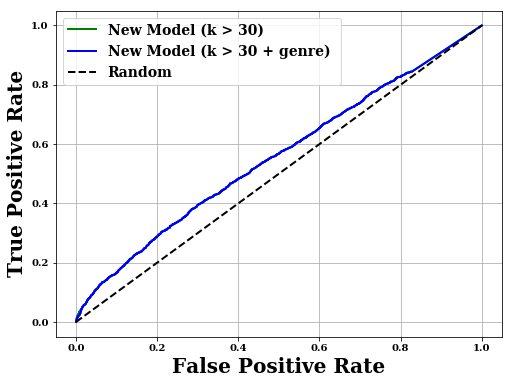

In [34]:
# recall, precision, and f1 are definied for binarized predictions  
# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2,color='green',label='New Model (k > 30)')
plt.plot(fpr_g, tpr_g, lw=2,color='blue',label='New Model (k > 30 + genre) ')
#plt.plot(fpr_w2, tpr_w2, lw=2,color='red',label='Old Model')

plt.plot([0, 1], [0, 1], 'k--',lw=2,label='Random')
#plt.title('ROC') # (AUC=%0.3f)' % auc_score)
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.grid(True)
plt.legend(fontsize=14)
plt.savefig('Plots/%s_%s_roc.png'%(week,day),bbox_to_inches='tight')

In [21]:
def recall_at_k(true, pred, user_ids, k, tol=2.5):
    unique_users = np.unique(user_ids)
    pred_binarized = binarize(pred.copy(), tol)
    #print(pred_binarized)
    recalls = np.zeros(unique_users.size)
    for i in range(unique_users.size):
        user_ind = user_ids == unique_users[i]
        user_true = true[user_ind]
        user_pred = pred[user_ind]
        user_pred_binarized = pred_binarized[user_ind]
        #print("in here",pred_binarized[user_ind])
        ranked_ind = np.argsort(-user_pred)[:k]
        recalls[i] = recall_score(user_true[ranked_ind], user_pred_binarized[ranked_ind])
    #print(recalls)
    return np.mean(recalls[recalls > 0])

In [22]:
user_ids = np.tile(np.array([np.arange(test_set.shape[0])]).T, (1, test_set.shape[1]))[nonzero_test]
#print(user_ids)
#print(y_true_binarized)

In [56]:
print( 'recall @4 : %0.3f' % recall_at_k(y_true_binarized, y_pred_topk, user_ids, 4))
print( 'recall @8 : %0.3f' % recall_at_k(y_true_binarized, y_pred_topk, user_ids, 8))
print( 'recall @16 : %0.3f' % recall_at_k(y_true_binarized, y_pred_topk, user_ids, 16))
print( 'recall @32 : %0.3f' % recall_at_k(y_true_binarized, y_pred_topk, user_ids, 32))

print( '\n\nrecall @4 : %0.3f' % recall_at_k(y_true_binarized, y_pred_topk_genre, user_ids, 4, tol=3))
print( 'recall @8 : %0.3f' % recall_at_k(y_true_binarized, y_pred_topk_genre, user_ids, 8, tol=3))
print( 'recall @16 : %0.3f' % recall_at_k(y_true_binarized, y_pred_topk_genre, user_ids, 16, tol=3))
print( 'recall @32 : %0.3f' % recall_at_k(y_true_binarized, y_pred_topk_genre, user_ids, 32, tol=3))

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


recall @4 : 0.468
recall @8 : 0.280
recall @16 : 0.151
recall @32 : 0.119


recall @4 : 0.479
recall @8 : 0.277
recall @16 : 0.150
recall @32 : 0.119


In [88]:
# Get the mean to add to predictions
Ymean = np.sum(ratings_mat.T,axis=1)/np.sum(binary_mat.T,axis=1)
Ymean = Ymean.reshape((Ymean.shape[0],1))
print(max(Ymean),min(Ymean))
#print(Ymean.shape)
#print(user_prediction)

user_i = 310
user_prediction_0 = user_prediction[user_i]  #+ Ymean.flatten() - 2
#print(max(user_prediction_0),min(user_prediction_0))

[5.] [1.]


In [89]:
# Sort first user's predictions from highest to lowest
pred_idxs_sorted = np.argsort(user_prediction_0)
pred_idxs_sorted = pred_idxs_sorted[::-1]
print(pred_idxs_sorted)

print( "Top recommendations for you:")
for i in range(8):
    
    c = int(pred_idxs_sorted[i])-1
    df_temp = df_ratings_cut.query('book_idx == %d' % c)
    #print(pred_idxs_sorted[i],df_temp.book_id.values)
    book_id = df_temp.book_id.values[0]    
    new_book = df_books.query('book_id == %d'%book_id)    
    print('Predicting rating %0.2f for book "%s"' % \
    (user_prediction_0[pred_idxs_sorted[i]],new_book['title'].values[0]))
    
j = 0
print ("\nOriginal ratings provided:")
for i in range(len(ratings_mat[user_i])):
    
    #print(i,user_i, sum(ratings_mat[user_i]))
    if ratings_mat[user_i][i] > 0:
        j += 1
        df_temp = df_ratings_cut.query('book_idx == %d' % i)
        book_id = df_temp.book_id.values[0]    
        new_book_2 = df_books.query('book_id == %d' % book_id)
        print ('Rated %d for "%s"' % (ratings_mat[user_i][i],new_book_2['title'].values[0]))
    
    if j > 4:
        break

[  30   15   32 ... 6398 2631 7336]
Top recommendations for you:
Predicting rating 2.07 for book "Gone Girl"
Predicting rating 2.06 for book "The Diary of a Young Girl"
Predicting rating 1.94 for book "Of Mice and Men"
Predicting rating 1.92 for book "Twilight (Twilight, #1)"
Predicting rating 1.89 for book "A Wrinkle in Time (A Wrinkle in Time Quintet, #1)"
Predicting rating 1.87 for book "Pride and Prejudice"


IndexError: index 0 is out of bounds for axis 0 with size 0

In [55]:
a = np.zeros((5,7))
a[0][0] = 3; a[4][3] = 2

nonzero_a = a > 0
print(a[nonzero_a])
print(a)

[3. 2.]
[[3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]]


In [ ]:
import requests
CLIENT_ID = 'qc6JdYnnj3G1fpQSsp4n1w'
CLIENT_SECRET = 'zD8IroPsQVDvco4V2u9h6hMgV1F3lsIO6FxKiq9eU'

In [ ]:
multi_r = requests.get('https://api.foursquare.com/v2/venues/search?client_id=CLIENT_ID&client_secret=CLIENT_SECRET')
